In [16]:
import pandas as pd
from utility.util import clean_columns

from matplotlib import pyplot as plt
from utility.util import plot_gender_fraction_over_time

import ipywidgets as widget

import os
import string
import zipfile
import shutil

In [17]:
qR = pd.read_csv("./utility/data/Lab 1 Quiz.csv")
qR.head()

,assignment_id,submission_id,student_id,user_id,name,email_address,question_number,question_title,question_content,graded,answers
0,1490397,87672128,465918.0,1199747,Abby Brand,abbybrand@wustl.edu,1.0,What is the one thing you learned from today's...,"[{""type"": ""text"", ""value"": ""Turn **off** scree...",False,"{""0"": ""I learned how to clean up a dataset fro..."
1,1490397,87672128,465918.0,1199747,Abby Brand,abbybrand@wustl.edu,2.1,What are the features of the iris dataset? Mar...,"[{""type"": ""select_all_input"", ""choices"": [{""va...",True,"{""0"": [""petal length"", ""petal width"", ""sepal w..."
2,1490397,87672128,465918.0,1199747,Abby Brand,abbybrand@wustl.edu,2.2,How many data points are in your training set?,"[{""type"": ""text"", ""value"": """"}, {""type"": ""radi...",True,"{""0"": ""105""}"
3,1490397,87672128,465918.0,1199747,Abby Brand,abbybrand@wustl.edu,3.1,Which feature did you use for predictions?,"[{""type"": ""text"", ""value"": """"}, {""type"": ""free...",False,"{""0"": ""We used petal width for the predictions..."
4,1490397,87672128,465918.0,1199747,Abby Brand,abbybrand@wustl.edu,3.2,What was the average prediction accuracy for t...,"[{""type"": ""text"", ""value"": """"}, {""type"": ""free...",False,"{""0"": ""The average prediction accuracy was 88...."


In [18]:
iCare = qR[['question_number','graded','answers','question_content']]
# iCare.iloc[8]['question_content']
iCare[:20]

,question_number,graded,answers,question_content
0,1.0,False,"{""0"": ""I learned how to clean up a dataset fro...","[{""type"": ""text"", ""value"": ""Turn **off** scree..."
1,2.1,True,"{""0"": [""petal length"", ""petal width"", ""sepal w...","[{""type"": ""select_all_input"", ""choices"": [{""va..."
2,2.2,True,"{""0"": ""105""}","[{""type"": ""text"", ""value"": """"}, {""type"": ""radi..."
3,3.1,False,"{""0"": ""We used petal width for the predictions...","[{""type"": ""text"", ""value"": """"}, {""type"": ""free..."
4,3.2,False,"{""0"": ""The average prediction accuracy was 88....","[{""type"": ""text"", ""value"": """"}, {""type"": ""free..."
5,3.3,False,"{""0"": ""We might cosider adding other features,...","[{""type"": ""text"", ""value"": ""Turn **off** scree..."
6,4.1,True,"{""0"": ""I agree""}","[{""type"": ""radio_input"", ""choices"": [{""value"":..."
7,4.2,False,"{""0"": ""I agree with the statement because usin...","[{""type"": ""text"", ""value"": ""Turn **off** scree..."
8,4.3,True,"{""0"": ""I strongly agree""}","[{""type"": ""radio_input"", ""choices"": [{""value"":..."
9,4.4,False,"{""0"": ""I strongly agree with this statement be...","[{""type"": ""text"", ""value"": ""Turn **off** scree..."


In [19]:
def cleaning_up (df):
    new_df = df
    for i,j in new_df.iterrows():
#       changing the question content
        answers = new_df.iloc[i]['answers'].replace("0","").translate(str.maketrans("", "", string.punctuation))
        q_content = new_df.iloc[i]['question_content'].replace("0","").translate(str.maketrans("", "", string.punctuation))
        new_df.at[i, 'answers'] = answers
        new_df.at[i, 'question_content'] = q_content
#       changing the answer content
        if "We mark D and E" in new_df.at[i, 'question_content']:
            new_df.at[i, 'question_content'] = "abc_input"
            continue;
        elif "text" in new_df.at[i, 'question_content']:
            new_df.at[i, 'question_content'] = "text"
            continue;
        elif "selectallinput" in new_df.at[i, 'question_content']:
            new_df.at[i, 'question_content'] = "select_all_input"
            continue;
        elif "radioinput" in new_df.at[i, 'question_content']:
            new_df.at[i, 'question_content'] = "radio_input"
            continue;
    return new_df

clean = cleaning_up(iCare)
clean[:15]

,question_number,graded,answers,question_content
0,1.0,False,I learned how to clean up a dataset from obse...,text
1,2.1,True,petal length petal width sepal width sepal le...,select_all_input
2,2.2,True,15,text
3,3.1,False,We used petal width for the predictions thoug...,text
4,3.2,False,The average prediction accuracy was 8889 for ...,text
5,3.3,False,We might cosider adding other features such a...,text
6,4.1,True,I agree,radio_input
7,4.2,False,I agree with the statement because using DS a...,text
8,4.3,True,I strongly agree,radio_input
9,4.4,False,I strongly agree with this statement because ...,text


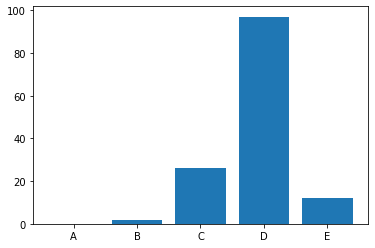

In [20]:
def ABC_input (df, q_num):
    answers = {
        "A" : 0,
        "B" : 0,
        "C" : 0,
        "D" : 0,
        "E" : 0
    }
    for i,j in df.iterrows():
        if df.iloc[i]['question_number'] == q_num:
            ans = str(df.iloc[i]['answers'])
            goal = ans[1]
            if goal == "A":
                answers["A"] += 1
            elif goal == "B":
                answers["B"] += 1
            elif goal == "C":
                answers["C"] += 1
            elif goal == "D":
                answers["D"] += 1
            elif goal == "E":
                answers["E"] += 1
                
    lists = sorted(answers.items())

    x, y = zip(*lists)

    plt.bar(x, y)
    plt.show()
                
ABC_input(clean, 5.1)       



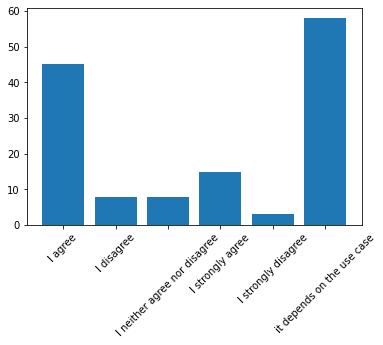

In [21]:
def radio_input (df, q_num):
    answers = {
        "I strongly disagree" : 0,
        "I disagree" : 0,
        "I neither agree nor disagree" : 0,
        "I agree" : 0,
        "I strongly agree" : 0,
        "it depends on the use case" : 0
    }
    for i,j in df.iterrows():
        if df.iloc[i]['question_number'] == q_num:
            goal = str(df.iloc[i]['answers'])
            if goal == " I strongly disagree":
                answers["I strongly disagree"] += 1
            elif goal == " I disagree":
                answers["I disagree"] += 1
            elif goal == " I neither agree nor disagree":
                answers["I neither agree nor disagree"] += 1
            elif goal == " I agree":
                answers["I agree"] += 1
            elif goal == " I strongly agree":
                answers["I strongly agree"] += 1
            elif goal == " it depends on the use case":
                answers["it depends on the use case"] += 1
    lists = sorted(answers.items())

    x, y = zip(*lists)

    plt.bar(x, y)
    plt.xticks(rotation = 45)
    plt.show()

radio_input(clean, 4.1)

In [15]:
def short_answer (df, q_num):
    for i,j in df.iterrows():
        if df.iloc[i]['question_number'] == q_num:
            ans = str(df.iloc[i]['answers'])
            print(ans)
            print()

short_answer(clean, 1.0)

 I learned how to clean up a dataset from observations and turn it into a prediction model

 I learned how to use plots like scatterplots and histograms

 I found todays lab to be quite useful in solidifying knowledge of numpy Specifically the exercises towards to end of graphing histograms and box plots were completely new to me In addition extra practice with string manipulation was very useful  I finally processed how to start at the end of the string instead of just the beginning

 I got a sneak peek into the Data science workflowgoing from a problem statement to cleaning data to honing on a set of features to building and evaluating a model I learned some of the intuition behind picking a certain kind of model for a given problem 

 I learned how to do basic evaluations of datasets with numpy including learning how to visualize the data to make better models build models based on inferences and evaluate models to improve them

 We learned more python techniques to use reshape NumP


 You can use numpy to scale data to make better conclusions about the iris data set and picking a good identifier Enumerate is also a helpful method that assigns index values to strings 

 I learned how to build a model with data and how to split the data into training and testing datasets

 I learned how to create graphs and proportionally scale data so that I can get bettermore easily interpreted results

 I learned how to sort data plot it and compare training values to test values in order to determine the best items to use to help achieve a task distinguishing flowers in this case

 One thing I learned from todays lab is usage and application of the enumerate action which acts as a counter and gives us an index value used for indexing 

 One thing I learned today is the importance of data visualization in the process of choosing good features for the machine learning process Looking at the histograms box plots and scatter plots were all imperative to better understanding the rela

In [12]:
def get_question_nums(df):
    count = 0
    first_num = df.iloc[0,6]
    for index,row in df.iterrows():
        print(df.iloc[index,6])
        count += 1
        index = index+1
        if(df.iloc[index,6] == first_num):
            break                 
get_question_nums(qR)

1.0
2.1
2.2
3.1
3.2
3.3
4.1
4.2
4.3
4.4
5.1
5.2
5.3
5.4
